1. Dog()
2. 

In [2]:
%matplotlib inline

import sys
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_laplace
from skimage.feature.peak import peak_local_max

from math import sqrt, hypot, log, pi

import itertools as itt

from skimage.filters import threshold_otsu, threshold_local

In [3]:
# loading tiff stack
stack_0 = sitk.ReadImage('../../../sample_data/cell_detection_0.tiff')
stack_0 = sitk.GetArrayFromImage(stack_0)
image_0 = stack_0 * np.float32(255.0 / stack_0.max())
# img_0 = stack_0 * np.uint16(255 / stack_0.max())
print('shape:', image_0.shape)
print('max:', image_0.max())
print('min:', image_0.min())

RuntimeError: Exception thrown in SimpleITK ReadImage: /scratch/dashboards/SimpleITK-OSX10.6-intel-pkg/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:74:
sitk::ERROR: The file "../../../sample_data/cell_detection_0.tiff" does not exist.

In [68]:
# params
min_sigma = 1
max_sigma = 50
num_sigma = 10
threshold = 0.2
overlap = 0.5
print_level = True
# ===

sigma_list = np.linspace(min_sigma, max_sigma, num_sigma)


# if log_scale:
#     start, stop = log(min_sigma, 10), log(max_sigma, 10)
#     sigma_list = np.logspace(start, stop, num_sigma)
# else:
#     sigma_list = np.linspace(min_sigma, max_sigma, num_sigma)

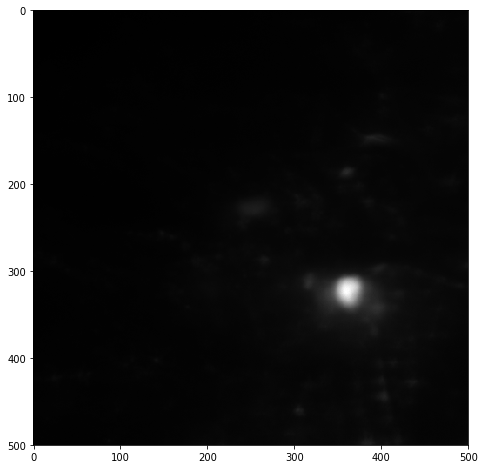

In [79]:
plt.figure(figsize=(8, 8))

# plt.subplot(1,2,1)
# plt.title('adaptive equilization')
plt.imshow(image[50,:,:], cmap=plt.cm.gray)

# plt.subplot(1,2,2)
# plt.imshow(z_slice, cmap=plt.cm.gray)

In [42]:
print(gl_images[0].shape)

(100, 500, 500)


In [45]:
image = np.copy(image_0)

# scale_space_L = []
# for sigma in sigma_list:
#         if print_level:
#             print("Sigma: {}".format(sigma))
#         # TODO: Do we need a inhouse gaussian filter to control filter size?
#         L = -gaussian_laplace(image, sigma) * sigma ** 2
#         scale_space_L.append((sigma, L))
        
        

# computing gaussian laplace
# s**2 provides scale invariance
gl_images = [-gaussian_laplace(image, s) * s ** 2 for s in sigma_list]
gl_scale_space = np.array(gl_images)


# image_cube = np.dstack(gl_images)

In [46]:
print(gl_scale_space.shape)

(10, 100, 500, 500)


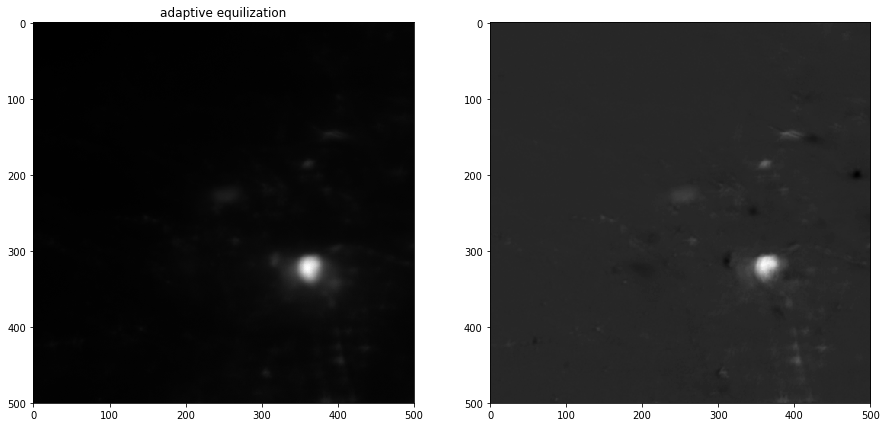

In [99]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
plt.imshow(image[50,:,:], cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(gl_scale_space[0][50,:,:], cmap=plt.cm.gray)

In [242]:
local_maxima = peak_local_max(gl_scale_space, threshold_abs=threshold,
#                               min_distance=3,
                              footprint=np.ones((3, 3, 3, 3)),
                              threshold_rel=0.0,
                              exclude_border=False)

# Catch no peaks
if local_maxima.size == 0:
    print('no peaks')
#     return np.empty((0,3))

In [243]:
# Convert local_maxima to float64
lm = local_maxima.astype(np.float64)
# Convert the last index to its corresponding scale value
lm[:, 0] = sigma_list[local_maxima[:, 0]]
local_maxima = lm

In [244]:
print(local_maxima.shape)
print(local_maxima)

(83751, 4)
[[  39.11111111   16.          499.          499.        ]
 [  39.11111111    0.          172.          499.        ]
 [  33.66666667   99.          499.          200.        ]
 ..., 
 [   1.            0.            0.          144.        ]
 [   1.            0.            0.           63.        ]
 [   1.            0.            0.           26.        ]]


In [245]:
col_permutation = [1,2,3,0]
# perm = np.argsort(col_permutation)
local_maxima= local_maxima[:,col_permutation]
print(local_maxima)

[[  16.          499.          499.           39.11111111]
 [   0.          172.          499.           39.11111111]
 [  99.          499.          200.           33.66666667]
 ..., 
 [   0.            0.          144.            1.        ]
 [   0.            0.           63.            1.        ]
 [   0.            0.           26.            1.        ]]


### Local Maxima 2

In [184]:
gl_thresh = threshold_otsu(gl_scale_space)
print(gl_thresh)

1.22493210062


In [185]:
local_maxima_2 = peak_local_max(gl_scale_space, threshold_abs=gl_thresh,
                                min_distance=10,
#                               footprint=np.ones((10, 10, 10, 10)),
                              threshold_rel=0.0,
                              exclude_border=False)
lm2 = local_maxima_2.astype(np.float64)
# Convert the last index to its corresponding scale value
lm2[:, 0] = sigma_list[local_maxima_2[:, 0]]
local_maxima_2 = lm2

print(local_maxima_2.shape)

(800, 4)


In [186]:
print(local_maxima_2)

[[  39.11111111    0.          172.          499.        ]
 [  33.66666667   99.          499.          200.        ]
 [  33.66666667   99.          424.            0.        ]
 ..., 
 [   1.            0.          190.          350.        ]
 [   1.            0.           65.          363.        ]
 [   1.            0.           64.          350.        ]]


In [187]:
col_permutation = [1,2,3,0]
# perm = np.argsort(col_permutation)
local_maxima_2 = local_maxima_2[:,col_permutation]
print(local_maxima_2)

[[   0.          172.          499.           39.11111111]
 [  99.          499.          200.           33.66666667]
 [  99.          424.            0.           33.66666667]
 ..., 
 [   0.          190.          350.            1.        ]
 [   0.           65.          363.            1.        ]
 [   0.           64.          350.            1.        ]]


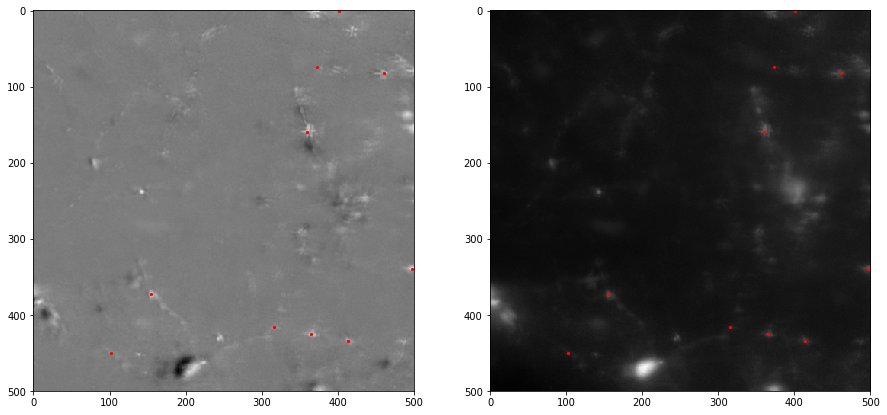

In [200]:
z = 90
sl = local_maxima_2[local_maxima_2[:,0] == z]
# print(sl)

plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
plt.scatter(sl[:,2], sl[:,1], s=5, color='red')
plt.imshow(gl_scale_space[0][z,:,:], cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.scatter(sl[:,2], sl[:,1], s=5, color='red')
plt.imshow(image[z,:,:], cmap=plt.cm.gray)

### original image

In [232]:
thresh = threshold_otsu(image) / 2
print(thresh)

15.0859120993


In [233]:
local_maxima_0 = peak_local_max(image, threshold_abs=thresh*2, 
                              min_distance=10,
#                               footprint=np.ones((10, 10, 10)),
                              threshold_rel=0.0,
                              exclude_border=False)
lm0= local_maxima_0.astype(np.float64)
# Convert the last index to its corresponding scale value
# lm0[:, 0] = sigma_list[local_maxima_0[:, 0]]
local_maxima_0 = lm0

print(local_maxima_0.shape)

(133, 3)


In [161]:
print(local_maxima_0)

[[  99.  136.  499.]
 [  99.  102.  352.]
 [  98.  469.  338.]
 [  98.   58.  491.]
 [  95.  129.  352.]
 [  94.  229.  406.]
 [  92.  392.   86.]
 [  89.  497.  372.]
 [  89.  383.    3.]
 [  88.  470.  197.]
 [  86.  400.   18.]
 [  86.  353.  129.]
 [  85.  463.  462.]
 [  84.  277.  406.]
 [  83.  163.  304.]
 [  82.  419.   26.]
 [  82.  404.   39.]
 [  81.  197.  374.]
 [  79.  336.  410.]
 [  79.  250.  394.]
 [  79.  166.  407.]
 [  78.   73.  441.]
 [  77.  315.  395.]
 [  77.  224.  377.]
 [  77.  167.   29.]
 [  77.  132.  136.]
 [  76.  405.  475.]
 [  76.  274.  422.]
 [  76.  230.  195.]
 [  75.  486.  341.]
 [  74.  483.   53.]
 [  74.  452.  425.]
 [  74.  446.  377.]
 [  73.  454.  456.]
 [  73.  297.  377.]
 [  72.  442.  336.]
 [  72.  415.  350.]
 [  72.  375.  484.]
 [  72.  335.  385.]
 [  72.  309.   70.]
 [  72.  124.  161.]
 [  71.  407.  431.]
 [  71.  356.  427.]
 [  71.  117.  106.]
 [  71.   92.  146.]
 [  69.  136.  411.]
 [  69.  125.  179.]
 [  67.  476.

[[  24.  288.   90.]
 [  24.  226.  485.]]


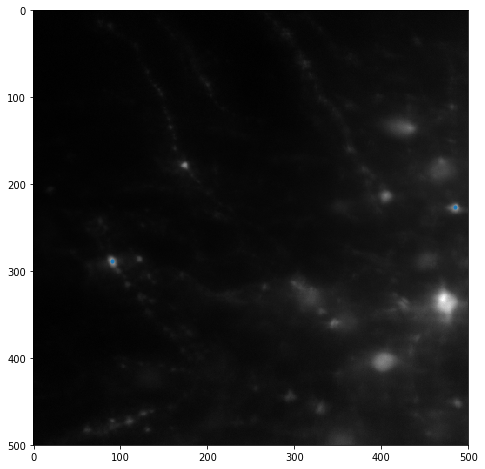

In [164]:
z = 24
slice_50 = local_maxima_0[local_maxima_0[:,0] == z]
print(slice_50)

plt.figure(figsize=(8, 8))
plt.scatter(slice_50[:,2], slice_50[:,1], s=10)
plt.imshow(image[z,:,:], cmap=plt.cm.gray)

In [89]:
col_permutation = [1,2,3,0]
# perm = np.argsort(col_permutation)
local_maxima_2 = local_maxima_2[:,col_permutation]
print(local_maxima_2)

[[  16.          499.          499.           39.11111111]
 [   0.          172.          499.           39.11111111]
 [  99.          499.          200.           33.66666667]
 ..., 
 [   0.            0.          402.            1.        ]
 [   0.            0.          144.            1.        ]
 [   0.            0.           26.            1.        ]]


## Pruning

In [189]:
def _prune_blobs(b_arr, overlap):
    # iterating again might eliminate more blobs, but one iteration suffices
    # for most cases
    blobs_array = np.copy(b_arr)
    
    for blob1, blob2 in itt.combinations(blobs_array, 2):
        if _blob_overlap(blob1, blob2) > overlap:
            if blob1[2] > blob2[2]:
                blob2[2] = -1
            else:
                blob1[2] = -1

    # return blobs_array[blobs_array[:, 2] > 0]
    return np.array([b for b in blobs_array if b[2] > 0])

In [205]:
def _blob_overlap(blob1, blob2):
    root = sqrt(3)

    # extent of the blob is given by sqrt(2)*scale
    r1 = blob1[3] * root
    r2 = blob2[3] * root

    d = hypot_3d(blob1[0] - blob2[0], blob1[1] - blob2[1], blob1[2] - blob2[2])

    if d > r1 + r2:
        return 0

    # one blob is inside the other, the smaller blob must die
    if d <= abs(r1 - r2):
        return 1

    ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
    ratio1 = np.clip(ratio1, -1, 1)
    acos1 = np.arccos(ratio1)

    ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
    ratio2 = np.clip(ratio2, -1, 1)
    acos2 = np.arccos(ratio2)

    a = -d + r2 + r1
    b = d - r2 + r1
    c = d + r2 - r1
    d = d + r2 + r1
    area = r1 ** 2 * acos1 + r2 ** 2 * acos2 - 0.5 * sqrt(abs(a * b * c * d))

    return area / (pi * (min(r1, r2) ** 2))

In [206]:
def hypot_3d(x, y, z):
    return sqrt(x*x + y*y + z*z)

In [207]:
output = _prune_blobs(local_maxima_2, overlap)

In [209]:
print(output.shape)
print(output)

(778, 4)
[[   0.          172.          499.           39.11111111]
 [  99.          466.          336.            6.44444444]
 [  99.           55.          401.            6.44444444]
 ..., 
 [   0.          190.          350.            1.        ]
 [   0.           65.          363.            1.        ]
 [   0.           64.          350.            1.        ]]


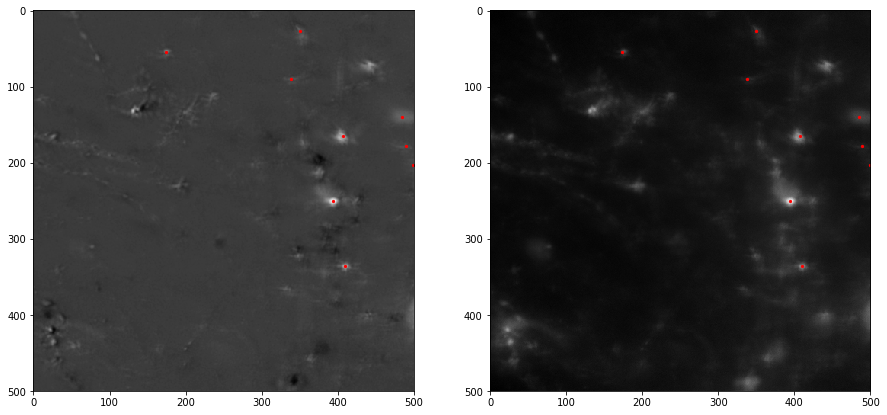

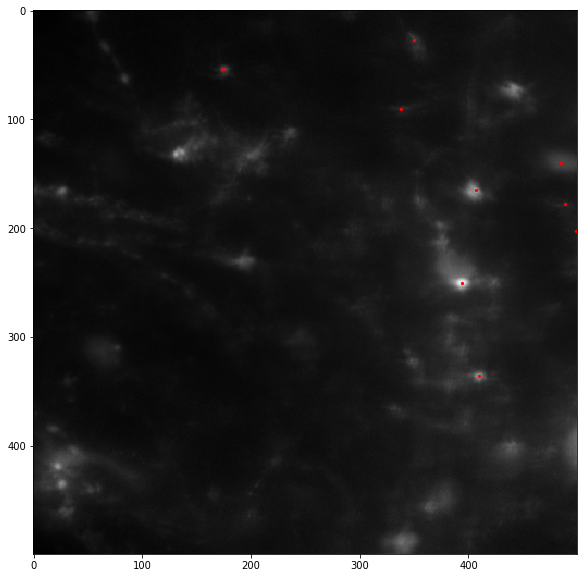

In [256]:
z = 79
sl_0 = output[output[:,0] == z]
# print(sl)

plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
plt.scatter(sl_0[:,2], sl_0[:,1], s=5, color='red')
plt.imshow(gl_scale_space[0][z,:,:], cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.scatter(sl_0[:,2], sl_0[:,1], s=5, color='red')
plt.imshow(image[z,:,:], cmap=plt.cm.gray)

plt.figure(figsize=(10, 10))
plt.scatter(sl_0[:,2], sl_0[:,1], s=5, color='red')
plt.imshow(image[z,:,:], cmap=plt.cm.gray)

In [10]:
a = [1, 2, 3, 4, 5]
shp = (len(a),) + stack_0.shape
print(shp)
asdf = np.empty(shp, dtype=stack_0.dtype)
print(asdf.shape)

(5, 100, 500, 500)
(5, 100, 500, 500)


In [12]:
def local_minima(data, threshold):
    if threshold is not None:
        peaks = data < threshold
    else:
        peaks = np.ones(data.shape, dtype=data.dtype)

    peaks &= data == ndimage.filters.minimum_filter(data, size=(3,) * data.ndim)
    return np.transpose(np.nonzero(peaks))

In [ ]:
# params:
img = np.copy(stack_0)
sigmas = np.linspace(2, 10, 10)
# ===

log = np.empty((len(sigmas),) + img.shape, dtype=img.dtype)
for slog, sigma in zip(log, sigmas):
    slog[...] = sigma ** 2 * gaussian_laplace(img, scale)

peaks = local_minima(log, threshold=threshold)
peaks[:, 0] = scales[peaks[:, 0]]

In [ ]:
for sigma in np.linspace(2, 10, 10):
    if print_level:
        print("Sigma: {}".format(sigma))
    scale_constant = np.power(sigma, gamma - 1)
    # TODO: Do we need a inhouse gaussian filter to control filter size?
    G_1 = ndimage.filters.gaussian_filter(img, sigma+a) 
    G_2 = ndimage.filters.gaussian_filter(img, sigma)
    DoG = scale_constant * (G_1 - G_2)/a
    DoG_stack.append((sigma,DoG))